# Tensile Creep Tests on Tissue Slices of Norway Spruce
#### *A. Ferrara and F.K. Wittel (2025), "Tensile Creep of Norway Spruce on the Tissue Scale"* in *Mechanics of Time-Dependent Materials*

This Notebook allows to manipulate and plot the data contained in **_Creep_Tests_Dataset_** ([10.17632/vmvpvjj4g3.1](https://data.mendeley.com/datasets/vmvpvjj4g3/1)). The dataset presents experimental results from **tensile creep tests** performed on **tissue slices of Norway Spruce**, tested across different anatomical orientations - longitudinal (L), radial (R), and tangential (T) - and at varying **relative humidity (RH)** levels of 30%, 65%, and 90%, corresponding to **moisture contents (mc)** of 0.07, 0.12, and 0.2, respectively. The tissue samples were sliced in all orientations: **{LR, RL, RT, TR, LT}**, where the first letter indicates the longest dimension and the second represents the width. {LR,RL,RT,TR} are characterized by alternating bands of earlywood (EW) and latewood (LW). For LT, different tissues were isolated for EW and LW: {LT-EW, LT-LW}. Moreover, the samples were tested at two different **loading degrees (LD)** of approximately 30% and 50% of the tensile strength. Note that the reference values of the tensile strength corresponding to 30%, 65%, and 90% RH were previously determined in [*Ferrara and Wittel (2024)*](https://doi.org/10.1515/hf-2024-0046). 

The dataset is organized by sample type, with each file containing multiple sheets, one for each tested sample. Each sheet provides detailed information about the sample, including its dimensions, RH during experiment, applied load, loading degree, and failure stress (if available). Moreover, time, creep strain, and creep compliance measurements are recorded for each test. Additionally, the dataset contains a CSV file that includes the elastic stiffness values determined in our previous work (*Ferrara and Wittel, 2024*). These values are useful for studying how creep compliance scales with the elastic compliances.

## Data path and imports
Run the following section to import the required libraries and download the data folder in the current directory. 

In [1]:
# Import libraries
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display, clear_output
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
%matplotlib widget

# Download dataset in the current folder
url = "https://data.mendeley.com/public-files/datasets/vmvpvjj4g3/files/51e61eb6-c494-4d2e-be9b-e4eaff2acdae/file_downloaded" # Link to dataset folder
extraction_path = os.getcwd()  # path to current folder
zip_file_path = os.path.join(extraction_path, "downloaded_folder.zip")  # path to folder where the zip file will be saved
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"} # get headers (optional, but recommended for some sites)
response = requests.get(url, headers=headers) # get response from URL
if response.status_code == 200:
    with open(zip_file_path, "wb") as f:  # download the zip file
        f.write(response.content)   
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:  # unzip the file
            zip_ref.extractall(extraction_path)
        extracted_file = zip_ref.namelist()[0]  # name of the extracted folder
        folder_path = os.path.join(extraction_path, extracted_file) # path to dataset folder
        print(f"Working in: {folder_path}")
        os.remove(zip_file_path)  # remove the downloaded zip file
    except zipfile.BadZipFile:
        print("Error: The file is not a zip file or it is corrupted.")
else:
    print(f"Failed to download. Status code: {response.status_code}")

Working in: C:\Users\Falk\Documents\Creep_Tests_Dataset/


## Custom functions
Run the following section to make the custom functions available for use in the rest of the notebook.

In [2]:
# Functions
# Convert strings to floats, handling apostrophes
def safe_float_conversion(value):
    try:
        return float(str(value).replace("'", "").strip())
    except ValueError:
        return None
    
# Convert RH to mc, handling apostrophes
def safe_RH_conversion(value):
    try:
        value = float(str(value).replace("'", "").strip())

        # Replace RH values with moisture contents
        replacements = {65: 0.12, 90: 0.2, 30: 0.07}
        return replacements.get(value, value)  # Return replaced value if it exists, else return original value

    except ValueError:
        return None

# Load data from a specific sheet
def load_sheet_data(sheet_name, xls):
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=22)
    metadata_df = pd.read_excel(xls, sheet_name=sheet_name, nrows=22, header=None)
    metadata = {
        'Sample': metadata_df.iloc[1, 1],
        'mc [-]': safe_RH_conversion(metadata_df.iloc[15, 1]),  # Moisture content
        'Loading Degree [-]': safe_float_conversion(metadata_df.iloc[13, 1]),  # Nominal loading degree
        'Creep Stress [MPa]': safe_float_conversion(metadata_df.iloc[10, 1]),  # Creep stress
        'Comp_i': [safe_float_conversion(metadata_df.iloc[17, 1]), safe_float_conversion(metadata_df.iloc[18, 1]), 
                   safe_float_conversion(metadata_df.iloc[19, 1]), safe_float_conversion(metadata_df.iloc[20, 1])]  # Compliances of KV elements
    }
    df.columns = ['Time', 'Creep_Strain', 'Creep_Compliance']  
    df['Creep_Compliance'] = pd.to_numeric(df['Creep_Compliance'], errors='coerce')
    df['Creep_Strain'] = pd.to_numeric(df['Creep_Strain'], errors='coerce')
    
    return metadata, df

# Get a list of Excel file paths from the specified folder
def get_excel_file_paths(folder_path):
    return [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(('.xlsx', '.xls'))]

# Load data from multiple excel files
def load_excel_data(file_paths):
    
    sheet_info = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        sample_type = file_name.split('_')[0]  # Get sample type

        # Load the Excel file
        xls = pd.ExcelFile(file_path)       
        for sheet in xls.sheet_names:
            mc_value = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
            # Store RH values associated with sample type
            if sample_type not in sheet_info:
                sheet_info[sample_type] = set()
            sheet_info[sample_type].add(mc_value)
    
    return sheet_info

# Create dropdown widgets (sample type, mc, samples) for plot selection 
def create_dropdown_widget_sample(folder_path, ax):
    
    excel_file_paths = get_excel_file_paths(folder_path)
    sheet_info = load_excel_data(excel_file_paths)
    
    # Initialize widgets
    style = {'description_width': '150px'}
    sample_type_dropdown = widgets.Dropdown(options=list(sheet_info.keys()), description='Sample Type:', disabled=False, style=style)
    mc_dropdown = widgets.Dropdown(description='Moisture Content [-]:', disabled=False, style=style)
    sheet_dropdown = widgets.Dropdown(description='Sample:', disabled=False, style=style)


    def initialize_selections():
        # Initialize selections and update dropdowns
        current_sample_type = list(sheet_info.keys())[0]  # Get the first sample type
        sample_type_dropdown.options = list(sheet_info.keys())  # Set sample type options
        sample_type_dropdown.value = current_sample_type  # Set initial sample type
        mc_values = list(sheet_info[current_sample_type])
        mc_dropdown.options = mc_values           
        # Reset RH selection if current value is not valid
        mc_dropdown.value = mc_values[0] if mc_values else None

    def update_mc_values(change):
        selected_sample_type = change['new']
        # Update RH values based on selected sample type
        mc_values = list(sheet_info[selected_sample_type])
        mc_dropdown.options = mc_values            
        # Reset RH selection if current value is not valid
        mc_dropdown.value = mc_values[0] if mc_values else None
        # Update sheet options based on current selections
        update_sheet_options(selected_sample_type, mc_dropdown.value)

    def update_sheet_options(selected_sample_type, selected_mc):
        # Update available sheet options based on selected test and sample types, filtered by RH
        available_sheets = []   
        # Iterate through all Excel files to find matching sheets
        for file_path in excel_file_paths:
            file_name = os.path.basename(file_path)
            file_sample_type = file_name.split('_')[0]           
            # Check if file matches selected test type and sample type
            if file_sample_type == selected_sample_type:
                xls = pd.ExcelFile(file_path)
                for sheet in xls.sheet_names:
                    # Check the RH value for the sheet
                    sheet_mc = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
                    if sheet_mc == selected_mc:
                        available_sheets.append(sheet)        
        # Update sheet dropdown with unique options
        sheet_dropdown.options = list(set(available_sheets))
        sheet_dropdown.value = sheet_dropdown.options[0] if sheet_dropdown.options else None

    def update_plot(selected_sample_type, selected_mc, selected_sheet):
       
        if selected_sample_type and selected_mc is not None and selected_sheet is not None:
            # Find the correct file path for the selected test and sample type
            for file_path in excel_file_paths:
                file_name = os.path.basename(file_path)
                file_sample_type = file_name.split('_')[0]

                if file_sample_type == selected_sample_type:
                    plot_compliance_time_curve(ax, selected_sheet, pd.ExcelFile(file_path))  # Plot the selected sheet
                    break
            else:
                print("No valid file found for the selected test type and sample type.")  # Handle case if no valid file

    # Observe changes in dropdowns
    sample_type_dropdown.observe(update_mc_values, names='value')
    mc_dropdown.observe(lambda change: update_sheet_options(sample_type_dropdown.value, change['new']), names='value')
    sheet_dropdown.observe(lambda change: update_plot(sample_type_dropdown.value, mc_dropdown.value, change['new']), names='value')

    display(sample_type_dropdown, mc_dropdown, sheet_dropdown)
    initialize_selections()

    return

# Plot compliance-time curve with KV-fitting
def plot_compliance_time_curve(ax, sheet_name, xls):
    ax.cla()
    metadata, data = load_sheet_data(sheet_name, xls)

    # Plot original data
    sample = metadata['Sample']      
    time = data['Time']
    compliance = data['Creep_Compliance']
    ax.scatter(time, compliance, marker='o', s=20, color='red', label='Experimental data')
        
    # Plot fitted data
    comp_i = np.array(metadata['Comp_i'])
    tau = np.array([0.1, 1, 10, 100])
    max_time = time.iloc[-1]
    tdata_fit = np.linspace(0, max_time, 1000)
    def fun(comp_i, tau_i):
        return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))    
    responsedata = fun(comp_i, tau)
    # Calculate R² (Coefficient of determination)
    SS_tot = np.sum((compliance - np.mean(compliance))**2)
    responsedata_interp = np.interp(time, tdata_fit, responsedata)
    residuals = np.array(compliance) - responsedata_interp
    SS_res = np.sum(residuals**2)
    R_squared = 1 - (SS_res / SS_tot)
    ax.plot(tdata_fit, responsedata, '-', color='blue', linewidth=1.5, label='Fitting (R²=' + str(round(R_squared,2)) + ')')

    # Set plot
    labelsize = 16
    # Activate grid
    ax.grid(True, alpha=0.5)
    # Set y-axis
    ax.set_ylabel(r'J$_{c}$ [MPa$^{-1}$]', fontsize=labelsize)
    ax.set_ylim(bottom=0)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.get_yaxis().get_offset_text().set_text("")
    ax.yaxis.get_offset_text().set_fontsize(labelsize)
    # Set x-axis
    ax.set_xlabel('Time [h]', fontsize=labelsize)
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=labelsize)
    # Set legend
    ax.legend(loc='lower right', fontsize=labelsize)
    # Set title
    ax.set_title(sample + ' (' + str(metadata['mc [-]']) + ' mc - ' +
                 str(int(metadata['Loading Degree [-]']*100)) + '% load. deg.)', fontsize=labelsize)

    return

# Create dropdown widgets (sample type, mc) for plot selection 
def create_dropdown_widget(folder_path, ax):

    excel_file_paths = get_excel_file_paths(folder_path)
    sheet_info = load_excel_data(excel_file_paths)
    
    # Initialize widgets
    style = {'description_width': '150px'}
    sample_type_dropdown = widgets.Dropdown(options=list(sheet_info.keys()), description='Sample Type:', disabled=False, style=style)
    mc_dropdown = widgets.Dropdown(description='Moisture Content [-]:', disabled=False, style=style)

    # Slider for selecting max time in hours
    max_time_slider = widgets.IntSlider(value=150, min=1, max=500, step=1, layout=widgets.Layout(width='380px'),
        description='Max Time [h]:', style={'description_width': '150px'}, continuous_update=False)

    def initialize_selections():
        # Initialize dropdown selections and display widgets
        current_sample_type = list(sheet_info.keys())[0]  
        sample_type_dropdown.options = list(sheet_info.keys())  
        sample_type_dropdown.value = current_sample_type  
        mc_values = list(sheet_info[current_sample_type])
        mc_dropdown.options = mc_values           
        mc_dropdown.value = mc_values[0] if mc_values else None

    def update_mc_values(change):
        # Update moisture content options when sample type changes
        selected_sample_type = change['new']
        mc_values = list(sheet_info[selected_sample_type])
        mc_dropdown.options = mc_values            
        mc_dropdown.value = mc_values[0] if mc_values else None
        update_plot(selected_sample_type, mc_dropdown.value, max_time_slider.value)

    def update_plot(selected_sample_type, selected_mc, max_time):
        if selected_sample_type and selected_mc is not None:
            for file_path in excel_file_paths:
                file_name = os.path.basename(file_path)
                file_sample_type = file_name.split('_')[0]

                if file_sample_type == selected_sample_type:
                    plot_all_curves(ax, selected_sample_type, selected_mc, excel_file_paths, max_time)  
                    break
            else:
                print("No valid file found for the selected test type and sample type.")  

    # Observe changes
    sample_type_dropdown.observe(update_mc_values, names='value')
    mc_dropdown.observe(lambda change: update_plot(sample_type_dropdown.value, change['new'], max_time_slider.value), names='value')
    max_time_slider.observe(lambda change: update_plot(sample_type_dropdown.value, mc_dropdown.value, change['new']), names='value')

    display(sample_type_dropdown, mc_dropdown, max_time_slider)
    initialize_selections()  # Initialize and display everything

    return

# Plot compliance-time curves sorted by sample type and mc
def plot_all_curves(ax, sample_type, mc_value, file_paths, max_time):
    
    # Close all previous figures before starting a new plot
    ax.cla()  
    # Create figure
    #fig, ax = plt.subplots(figsize=(12, 8))

    def set_LD_color_map(LD):
        # Create color map for LD
        magma_cmap = sns.color_palette("magma", as_cmap=True)
        magma_seg = 3
        num_samples = 8
        colors = magma_cmap(np.linspace(0, 1, magma_seg*num_samples))
        if LD == 0.5: idx_seg = 1*num_samples
        elif LD == 0.3: idx_seg = 2*num_samples
        color_map = colors[idx_seg:idx_seg+num_samples+1]

        return color_map
    
    fitted_curves = []
    R_squared = []
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_sample_type = file_name.split('_')[0]
        
        if file_sample_type == sample_type:
            count_30 = 0
            count_50 = 0
            xls = pd.ExcelFile(file_path)
            for sheet in xls.sheet_names:
                sheet_mc = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
                if sheet_mc == mc_value:
                    # Load datasets
                    metadata, data = load_sheet_data(sheet, xls)
                    # Set color map
                    color_map = set_LD_color_map(metadata['Loading Degree [-]'])
                    if metadata['Loading Degree [-]'] == 0.3:
                        sample_color = color_map[count_30]
                        count_30 += 1
                    else:
                        sample_color = color_map[count_50]
                        count_50 += 1

                    # Plot original data
                    sample = metadata['Sample']      
                    time = data['Time']
                    compliance = data['Creep_Compliance']
                    ax.scatter(time, compliance, marker='o', s=20, color=sample_color, label=sample + ' - Exp. data')
                        
                    # Calculate fitting
                    comp_i = np.array(metadata['Comp_i'])
                    tau = np.array([0.1, 1, 10, 100])
                    tdata_fit = np.linspace(0, max_time, 1000)
                    def fun(comp_i, tau_i):
                        return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))    
                    responsedata = fun(comp_i, tau)
                    
                    # Calculate R² (Coefficient of determination)
                    SS_tot = np.sum((compliance - np.mean(compliance))**2)
                    responsedata_interp = np.interp(time, tdata_fit, responsedata)
                    residuals = np.array(compliance) - responsedata_interp
                    SS_res = np.sum(residuals**2)
                    R_squared.append(1 - (SS_res / SS_tot))
                    # Plot fitted data
                    ax.plot(tdata_fit, responsedata, '-', color=sample_color, linewidth=1.5, label=sample + ' - Fitting (R²=' + str(round(R_squared[-1],2)) + ')')
                    # Add fitted curve to the list
                    fitted_curves.append(responsedata)

    # Calculate and fit mean curve
    mean_curve = np.mean(fitted_curves, axis=0)
    mean_R_squared = np.mean(R_squared)

    def prony_response(gamma_i, tdata, tau_0):
        return (np.sum(gamma_i) - np.sum(gamma_i[:, None] * np.exp(-tdata / tau_0[:, None]), axis=0)) 

    def objective(gamma_i):
        # Define the objective function (Sum of Squares Error)
        predicted_response = prony_response(gamma_i, tdata_fit, tau)
        relative_error = np.sum(((predicted_response[1:] - mean_curve[1:]) / mean_curve[1:]) ** 2)
        return relative_error

    # Initial guess for optimization variables
    N = len(tau)  # Number of Prony terms
    gamma_0 = np.ones(N)
    initial_comp_i = gamma_0
    # Perform the optimization
    result = minimize(objective, initial_comp_i, bounds=[(0, None)] * N, options={'maxiter': 500})
    # Get the optimized Prony coefficients
    sol_comp_i = result.x
    formatted_val = [f'{x:.1e}'.lstrip('0') for x in sol_comp_i]
    formatted_val = [s.replace('e-0', 'e-') for s in formatted_val]
    ax.plot(tdata_fit, mean_curve, '--', color='red', linewidth=3, label='Mean Fitting (' + r"$C_{i}^{-1}$" + f"= [{', '.join(formatted_val)}])")

    # Set plot
    labelsize = 16
    # Activate grid
    ax.grid(True, alpha=0.5)
    # Set y-axis
    ax.set_ylabel(r'J$_{c}$ [MPa$^{-1}$]', fontsize=labelsize)
    ax.set_ylim(bottom=0)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.get_yaxis().get_offset_text().set_text("")
    ax.yaxis.get_offset_text().set_fontsize(labelsize)
    # Set x-axis
    ax.set_xlabel('Time [h]', fontsize=labelsize)
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=labelsize)
    # Set legend
    handles, labels = ax.get_legend_handles_labels()
    legend_handle_1 = mlines.Line2D([0], [0], color='black', label='Experimental data', marker='o', markersize=5, linestyle='None')
    legend_handle_2 = mlines.Line2D([0], [0], color='black', label='Fitting (Mean R²=' + str(round(mean_R_squared, 2)) + ')', linestyle='-', markersize=5)
    new_handles = [legend_handle_1, legend_handle_2, handles[-1]]
    new_labels = ['Experimental data', 'Fitting (Mean R²=' + str(round(mean_R_squared, 2)) + ')', labels[-1]]
    ax.legend(handles=new_handles, labels=new_labels, loc='lower right', fontsize=labelsize-2)
    # Set title
    ax.set_title(sample_type + ' samples (' + str(metadata['mc [-]']) + ' mc)', fontsize=labelsize)
    
    return

# Create time slider for boxplots selection
def create_time_slider_LD(folder_path, ax):
    # Slider for selecting max time in hours
    max_time_slider = widgets.IntSlider(value=150, min=1, max=500, step=1, layout=widgets.Layout(width='380px'),
        description='Time [h]:', style={'description_width': '150px'}, continuous_update=False)

    def update_plot(max_time):
        # Generate the plot
        boxplots_LD(ax, folder_path, max_time)

    # Observe slider changes and update plot
    max_time_slider.observe(lambda change: update_plot(change['new']), names='value')
    # Display the slider and output area
    display(max_time_slider)   
    # Initialize with the first plot
    update_plot(max_time_slider.value)

    return

# Set boxplots layout
def set_boxplot_layout(axes, val, edgecolor, xname='', labelsize=16, xticks='', ticksize=16, titlename='', titlesize=16):
        
    # Set colors
    for ax in axes:
        # Set legend edge color
        for i, legpatch in enumerate(ax.legend_.get_patches()):
            col = edgecolor[i%len(val)] if len(edgecolor)!=1 else edgecolor[0]
            legpatch.set_edgecolor(col)
        # Set box edges color
        box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
        num_patches = len(box_patches)
        lines_per_boxplot = len(ax.lines) // num_patches
        for i, patch in enumerate(box_patches):
            col = edgecolor[i*len(edgecolor)//num_patches] if len(edgecolor)!=1 else edgecolor[0]
            patch.set_edgecolor(col) # set perimeter color
            # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them and use the same color as above
            for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)

    # Set axes
    for ax in axes:
        #plt.sca(ax) # set current axes
        ax.set_ylim(bottom=0)
        ax.set_xlabel(xname, fontsize=labelsize)
        if xticks!='':
            ax.set_xticks(np.arange(0,len(xticks)))
            ax.set_xticklabels(xticks)
        ax.tick_params(axis='both', labelsize=ticksize)
        # Set shared grid
        ymin, ymax = ax.get_ylim()
        ax.set_yticks(np.arange(ymin,ymax,(ymax-ymin)/5.))
        # Set scientific notation
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.get_offset_text().set_fontsize(labelsize)
    ax.yaxis.set_offset_position('right')
        
    # Set title
    if titlename!='': ax.set_title(titlename, fontsize=titlesize)        

    return axes

# Set boxplots position
def set_box_position(mc, offset, sample_type, data):

    mc_to_float = {mc[0]: offset[0], mc[1]: offset[1], mc[2]: offset[2]}
    sample_to_position = {sample: idx for idx, sample in enumerate(sample_type)}
    data['x'] = data['mc [-]'].map(mc_to_float)
    data['y'] = data['sample'].map(sample_to_position)
    data['sample'] = data['x'] + data['y']
    data = data.drop(columns=['x', 'y'])

    return data

# Plot creep strain and compliances sorted by sample type, mc, and loading degree at selected time
def boxplots_LD(ax, folder_path, max_time):
    
    for axis in ax: axis.cla()

    def boxplot_LD_helper(ax1, ax2, folder_path, max_time, response_type):
        
        # Set color map for loading degrees
        LD = [30, 50]
        faceColor = {LD[0]: sns.color_palette("tab20c")[5], LD[1]: sns.color_palette("muted")[4]}
        edgeColor = [sns.color_palette("dark")[1], sns.color_palette("dark")[4]]

        # Boxplot settings
        width = 0.9
        linewidth = 1
        labelsize = 16

        # Organize data
        excel_file_paths = get_excel_file_paths(folder_path)
        samples = ["LT-LW", "LT-EW", "LR", "RL", "RT", "TR"]
        mc = [0.07, 0.12, 0.2]
        columns = ['mc [-]', 'Loading Degree [%]', 'sample', 'value']
        temp_df = []

        for sample_type in samples:
            for mc_value in mc:
                for file_path in excel_file_paths:
                    file_name = os.path.basename(file_path)
                    file_sample_type = file_name.split('_')[0]
                    if file_sample_type == sample_type:
                        xls = pd.ExcelFile(file_path)
                        for sheet in xls.sheet_names:
                            sheet_mc = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
                            if sheet_mc == mc_value:
                                # Load datasets
                                metadata, data = load_sheet_data(sheet, xls)
                                # Define the response function based on the response type
                                comp_i = np.array(metadata['Comp_i'])
                                tau = np.array([0.1, 1, 10, 100])
                                tdata_fit = np.linspace(0, max_time, 1000)
                                creep_stress = metadata['Creep Stress [MPa]']
                                if response_type == 'strain':
                                    def fun(comp_i, tau_i):
                                        return creep_stress * (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))
                                elif response_type == 'compliance':
                                    def fun(comp_i, tau_i):
                                        return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))
                                responsedata = fun(comp_i, tau)
                                temp_df.append([mc_value, int(metadata['Loading Degree [-]'] * 100), sample_type, responsedata[-1]])

        # Create dataframe
        temp_df = pd.DataFrame(data=temp_df, columns=columns)

        # Plot response
        PROPS = {'boxprops': {"alpha": 0.7}}
        cut = 3
        offset = np.array([round(value - mc[len(mc) // 2], 2) for value in mc]) * 5
        # Left y-axis (LT-LW, LT-EW, LR)
        temp_conc = []
        for t in range(len(samples) - cut):
            for mc_value in mc:
                for LD_value in LD:
                    temp_conc.append([mc_value, LD_value, samples[t + cut], np.nan])
        temp_conc = pd.DataFrame(data=temp_conc, columns=columns)
        data = pd.concat([temp_df[temp_df['sample'].isin(samples[:cut])], temp_conc], ignore_index=True)
        data = set_box_position(mc, offset, samples, data)
        sns.boxplot(ax=ax1, x='sample', y='value', hue='Loading Degree [%]', data=data, native_scale=True,
                    palette=faceColor, linewidth=linewidth, width=width, showfliers=False, showmeans=True, dodge=False, **PROPS)
        # Right y-axis (RL, RT, TR)
        temp_conc = []
        for t in range(cut):
            for mc_value in mc:
                for LD_value in LD:
                    temp_conc.append([mc_value, LD_value, samples[t], np.nan])
        temp_conc = pd.DataFrame(data=temp_conc, columns=columns)
        data = pd.concat([temp_conc, temp_df[temp_df['sample'].isin(samples[cut:])]], ignore_index=True)
        data = set_box_position(mc, offset, samples, data)   
        sns.boxplot(ax=ax2, x='sample', y='value', hue='Loading Degree [%]', data=data, native_scale=True,
                    palette=faceColor, linewidth=linewidth, width=width, showfliers=False, showmeans=True, dodge=False, **PROPS)

        # Set boxplot layout
        ax1.grid(True, alpha=0.5)
        plotname = f'Creep Strain at {int(max_time)} h' if response_type == 'strain' else f'Creep Compliance at {int(max_time)} h'
        axes = set_boxplot_layout([ax1, ax2], LD, edgeColor, labelsize=labelsize, xticks=samples, ticksize=labelsize, titlename=plotname)

        # Plot vertical line
        pos = cut - 1 + offset[-1] + ((cut + offset[0]) - (cut - 1 + offset[-1])) / 2
        ax1.axvline(pos, color='k', linestyle='--', linewidth=linewidth)

        # Set y-axes label and legend
        # Left y-axis
        if response_type == 'strain':
            axes[0].set_ylabel(r'$\epsilon_{c}$ [-]', fontsize=labelsize, va='center', labelpad=15)
            axes[1].set_ylabel(r'$\epsilon_{c}$ [-]', fontsize=labelsize, rotation=-90, va='center', labelpad=20)
            axes[1].yaxis.set_label_position('right')
            for axis in axes:
                if len(axes)==1 : loc = "best"
                else: loc = "upper left"
                handles, labels = axis.get_legend_handles_labels()
                labels = [f"{int(x)}%" for x in LD]
                axis.legend(handles=handles, labels=labels, title='Loading Degree (LD)', bbox_to_anchor=(0.5, 1), loc=loc)
                for i, legpatch in enumerate(axis.legend_.get_patches()):
                    col = edgeColor[i%len(LD)]
                    legpatch.set_edgecolor(col)
                plt.setp(axis.get_legend().get_texts(), fontsize=labelsize-2) 
                plt.setp(axis.get_legend().get_title(), fontsize=labelsize-2)

        elif response_type == 'compliance':
            ax1.set_ylabel(r'$J_{c}$ [MPa$^{-1}$]', fontsize=labelsize, va='center', labelpad=15)
            ax2.set_ylabel(r'$J_{c}$ [MPa$^{-1}$]', fontsize=labelsize, rotation=-90, va='center', labelpad=20)
            axes[1].yaxis.set_label_position('right')
            for ax in axes: ax.legend_.remove()
            # Add mc axis
            ymin, ymax = ax1.get_ylim()
            y_pos = (ymax-ymin)/2.
            shift = 0.18
            axes[0].annotate('', xytext=(offset[0]-shift, y_pos), xy=(offset[-1]+shift, y_pos),
                        arrowprops=dict(facecolor='black', arrowstyle='->'))
            axes[0].text(offset[-1]+1.5*shift, y_pos*0.98, 'mc', ha='right', va='top', fontsize=labelsize)
            y_pos = [(ymax-ymin)/2.*1.03, (ymax-ymin)/2.*0.84, (ymax-ymin)/2.*1.03]
            for x, y, num in zip(offset, y_pos, mc):
                axes[0].text(x, y, f'{num:.2f}', ha='center', va='bottom', fontsize=labelsize) 
                axes[0].plot([x, x], [(ymax-ymin)/2.*0.97, (ymax-ymin)/2.*1.03], color='black', lw=1)
        
        return axes

    # Plot creep strains
    boxplot_LD_helper(ax[0], ax[2], folder_path, max_time, response_type='strain')
    boxplot_LD_helper(ax[1], ax[3], folder_path, max_time, response_type='compliance')

    return

# Create time slider for boxplots selection
def create_time_slider_mc(folder_path, ax):
    # Slider for selecting max time in hours
    max_time_slider = widgets.IntSlider(value=150, min=1, max=500, step=1, layout=widgets.Layout(width='380px'),
        description='Time [h]:', style={'description_width': '150px'}, continuous_update=False)

    def update_plot(max_time):
        # Generate the plot
        boxplots_mc(ax, folder_path, max_time)

    # Observe slider changes and update plot
    max_time_slider.observe(lambda change: update_plot(change['new']), names='value')
    # Display the slider and output area
    display(max_time_slider)   
    # Initialize with the first plot
    update_plot(max_time_slider.value)

    return

# Set moisture content color map
def set_mc_color_map(mc):
    faceColor = {mc[0]:sns.color_palette("tab20c")[9], mc[1]:sns.color_palette("colorblind")[9], mc[2]:sns.color_palette("dark")[0]}
    edgeColor = [sns.color_palette("dark")[2], sns.color_palette("dark")[9], sns.color_palette("dark")[0]]
    return faceColor, edgeColor
  
# Plot compliances sorted by sample type and mc at selected time
def boxplots_mc(ax, folder_path, max_time):
    
    for axis in ax: axis.cla()
    # Set default values
    RH = [30, 65, 90]
    mc = [0.07, 0.12, 0.2]
    samples = ["LT-LW", "LT-EW", "LR", "RL", "RT", "TR"]
    columns = ['mc [-]', 'sample', 'value']
    
    # Set default path
    excel_file_paths = get_excel_file_paths(folder_path)

    # Set colors
    faceColor, edgeColor = set_mc_color_map(mc)
    
    # Boxplot settings
    width = 0.9
    linewidth = 1
    labelsize = 16

    def create_boxplot(ax1, ax2, temp_df, plotname=''):
        PROPS = {'boxprops':{"alpha": 0.7}}
        cut = 3
        offset = np.array([round(value - mc[len(mc) // 2], 2) for value in mc])*5
        # Left y-axis (LT-LW, LT-EW, LR)
        temp_conc = []
        for t in range(len(samples)-cut):
            for mc_value in mc:
                temp_conc.append([mc_value, samples[t+cut], np.nan])
        temp_conc = pd.DataFrame(data=temp_conc, columns=columns)
        data = pd.concat([temp_df[temp_df['sample'].isin(samples[:cut])], temp_conc], ignore_index=True)
        data = set_box_position(mc, offset, samples, data)
        sns.boxplot(ax=ax1, x='sample', y='value', hue='mc [-]', data=data, native_scale=True,
            palette=faceColor, linewidth=linewidth,  width=width, showfliers=False, showmeans=True, dodge=False, **PROPS)
        # Right y-axis (RL, RT, TR)
        temp_conc = []
        for t in range(cut):
            for mc_value in mc:
                temp_conc.append([mc_value, samples[t], np.nan])
        temp_conc = pd.DataFrame(data=temp_conc, columns=columns)
        data = pd.concat([temp_conc, temp_df[temp_df['sample'].isin(samples[cut:])]], ignore_index=True)
        data = set_box_position(mc, offset, samples, data)
        sns.boxplot(ax=ax2, x='sample', y='value', hue='mc [-]', data=data, native_scale=True,
            palette=faceColor, linewidth=linewidth,  width=width, showfliers=False, showmeans=True, dodge=False, **PROPS)

        # Set boxplot layout
        ax1.grid(True, alpha=0.5)
        axes = set_boxplot_layout([ax1, ax2], mc, edgeColor, labelsize=labelsize, xticks=samples, ticksize=labelsize, titlename=plotname)

        # Plot vertical line
        pos = cut-1 + offset[-1] + ((cut + offset[0]) - (cut-1 + offset[-1])) / 2
        axes[0].axvline(pos, color='k', linestyle='--', linewidth=linewidth)

        return axes

    def boxplot_compliances_mc(ax1, ax2, max_time):
        
        # Organize data
        LD = [30, 50]
        temp_df = []
        for sample_type in samples:
            for mc_value in mc:
                for file_path in excel_file_paths:
                    file_name = os.path.basename(file_path)
                    file_sample_type = file_name.split('_')[0]
                    if file_sample_type == sample_type:
                        xls = pd.ExcelFile(file_path)
                        for sheet in xls.sheet_names:
                            sheet_mc = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
                            if sheet_mc == mc_value:
                                # Load datasets
                                metadata, _ = load_sheet_data(sheet, xls)
                                # Plot fitted data
                                comp_i = np.array(metadata['Comp_i'])
                                tau = np.array([0.1, 1, 10, 100])
                                tdata_fit = np.linspace(0, max_time, 1000)
                                def fun(comp_i, tau_i):
                                    return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))    
                                responsedata = fun(comp_i, tau)
                                temp_df.append([mc_value, sample_type, responsedata[-1]])   
        # Create dataframe
        temp_df = pd.DataFrame(data=temp_df, columns=columns)

        # Plot creep compliances
        axes = create_boxplot(ax1, ax2, temp_df, f'Creep Compliance at {max_time} h')
        
        # Set legend
        for ax in axes:
            if len(axes)==1: loc = "best"
            else: loc = "upper left"
            handles, labels = ax.get_legend_handles_labels()
            labels = [f"{x}" for x in mc]
            ax.legend(handles=handles, labels=labels, title='mc [-]', loc=loc)
            for i, legpatch in enumerate(ax.legend_.get_patches()):
                col = edgeColor[i%len(LD)]
                legpatch.set_edgecolor(col)
            plt.setp(ax.get_legend().get_texts(), fontsize=labelsize-2) 
            plt.setp(ax.get_legend().get_title(), fontsize=labelsize-2)
        # Set y-axes limits and label
        # Left y-axis
        axes[0].set_ylabel(r'$J_{c}$ [MPa$^{-1}$]', fontsize=labelsize, ha='center', va='center', labelpad=15)
        # Right y-axis
        axes[1].set_ylabel(r'$J_{c}$ [MPa$^{-1}$]', fontsize=labelsize, rotation=-90, ha='center', va='center', labelpad=20)
        axes[1].yaxis.set_label_position('right')

        return axes

    def boxplot_elastic_compliances_mc(ax1, ax2, folder_path):
        
        # Organize data
        # Load elastic stiffnesses
        save_path = os.path.join(folder_path, "elastic_stiffnesses_Ferrara_Wittel_2024.csv")
        stiff_df = pd.read_csv(save_path)
        # Create compliances dataframe
        temp_df = []
        for t in range(len(samples)):
            for j in range(len(RH)):
                # Get strains data
                pos = np.where((np.isin(np.array(stiff_df['RH']), RH[j])) & (np.isin(np.array(stiff_df['sample_type']), samples[t])))[0]
                data = stiff_df.apply(lambda row: [row[i] for i in pos])
                for k in range(len(data['sample_name'])):
                    temp_df.append([mc[j], samples[t], 1./data['C0 [MPa]'][k]])
        temp_df = pd.DataFrame(data=temp_df, columns=columns)
        
        # Plot elastic compliances
        axes = create_boxplot(ax1, ax2, temp_df, f'Elastic Creep Compliance at {max_time} h')
        
        # Set legend
        for ax in axes: ax.legend_.remove()
        # Set y-axes limits and label
        # Left y-axis
        axes[0].set_ylabel(r'$C_{0}^{-1}$ [MPa$^{-1}$]', fontsize=labelsize, ha='center', va='center', labelpad=15)
        # Right y-axis
        axes[1].set_ylabel(r'$C_{0}^{-1}$ [MPa$^{-1}$]', fontsize=labelsize, rotation=-90, ha='center', va='center', labelpad=15)
        axes[1].yaxis.set_label_position('right')

        return axes

    def boxplot_normalized_compliances_mc(ax1, ax2, folder_path, max_time):
        
        # Organize data
        # Load elastic stiffnesses
        save_path = os.path.join(folder_path, "elastic_stiffnesses_Ferrara_Wittel_2024.csv")
        stiff_df = pd.read_csv(save_path)
        # Create compliances dataframe
        comp_df = []
        for t in range(len(samples)):
            for j in range(len(RH)):
                # Get strains data
                pos = np.where((np.isin(np.array(stiff_df['RH']), RH[j])) & (np.isin(np.array(stiff_df['sample_type']), samples[t])))[0]
                data = stiff_df.apply(lambda row: [row[i] for i in pos])
                for k in range(len(data['sample_name'])):
                    comp_df.append([mc[j], samples[t], 1./data['C0 [MPa]'][k]])
        comp_df = pd.DataFrame(data=comp_df, columns=columns)
        df_mean = comp_df.groupby(['sample', 'mc [-]']).mean().reset_index()
        # Create normalized compliances dataframe
        temp_df = []
        for sample_type in samples:
            for i in range(len(mc)):
                for file_path in excel_file_paths:
                    file_name = os.path.basename(file_path)
                    file_sample_type = file_name.split('_')[0]
                    if file_sample_type == sample_type:
                        xls = pd.ExcelFile(file_path)
                        for sheet in xls.sheet_names:
                            sheet_mc = safe_RH_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[15, 1])
                            if sheet_mc == mc[i]:
                                C0 = df_mean['value'][(df_mean['mc [-]']==mc[i]) & (df_mean['sample']==sample_type)].values[0]
                                # Load datasets
                                metadata, data = load_sheet_data(sheet, xls)
                                # Plot fitted data
                                comp_i = np.array(metadata['Comp_i'])
                                tau = np.array([0.1, 1, 10, 100])
                                tdata_fit = np.linspace(0, max_time, 1000)
                                def fun(comp_i, tau_i):
                                    return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata_fit / tau_i[:, None]), axis=0))    
                                responsedata = fun(comp_i, tau)/C0
                                temp_df.append([mc[i], sample_type, responsedata[-1]])   
        # Create dataframe
        temp_df = pd.DataFrame(data=temp_df, columns=columns)
        
        # Plot normalized compliances
        axes = create_boxplot(ax1, ax2, temp_df, f'Normalized Creep Compliance at {max_time} h')
        
        # Set legend
        for ax in axes: ax.legend_.remove()
        # Set y-axes limits and label
        # Left y-axis
        ax1.set_ylabel(r'J$_{c}$/$C_{0}^{-1}$', fontsize=labelsize, ha='center', va='center', labelpad=15)
        # Right y-axis
        ax2.set_ylabel(r'J$_{c}$/$C_{0}^{-1}$', fontsize=labelsize, rotation=-90, ha='center', va='center', labelpad=20)
        axes[1].yaxis.set_label_position('right')

        return axes

    # Plot creep compliances
    boxplot_compliances_mc(ax[0], ax[3], max_time)
    # Plot elastic compliances
    boxplot_elastic_compliances_mc(ax[1], ax[4], folder_path)
    # Plot normalized creep compliances
    boxplot_normalized_compliances_mc(ax[2], ax[5], folder_path, max_time)

    return

## Plot compliance-time curve of a sample
Run the following section to set up an interactive interface to plot the compliance-time curve of a specific sample. The interface provides 3 dropdown menus that allow you to customize the plot:

- **Sample Type** lists the different sample types you can choose from, such as **LT-EW**, **LT-LW**, **LR**, **RL**, **RT**, and **TR**.

- **Moisture Content [-]** lists the moisture contents available for selection: **0.07**, **0.12**, and **0.2**, corresponding to **30%**, **65%**, and **90%** relative humidity , respectively.

- **Sample** lists the available samples filtered by **Sample Type** and **mc**.

After selecting a sample from a combination of sample type and RH value, the corresponding compliance-time experimental data is plotted along with the Kelvin-Voigt series-based fitting.


Dropdown(description='Sample Type:', options=('LR', 'LT-EW', 'LT-LW', 'RL', 'RT', 'TR'), style=DescriptionStyl…

Dropdown(description='Moisture Content [-]:', options=(), style=DescriptionStyle(description_width='150px'), v…

Dropdown(description='Sample:', options=(), style=DescriptionStyle(description_width='150px'), value=None)

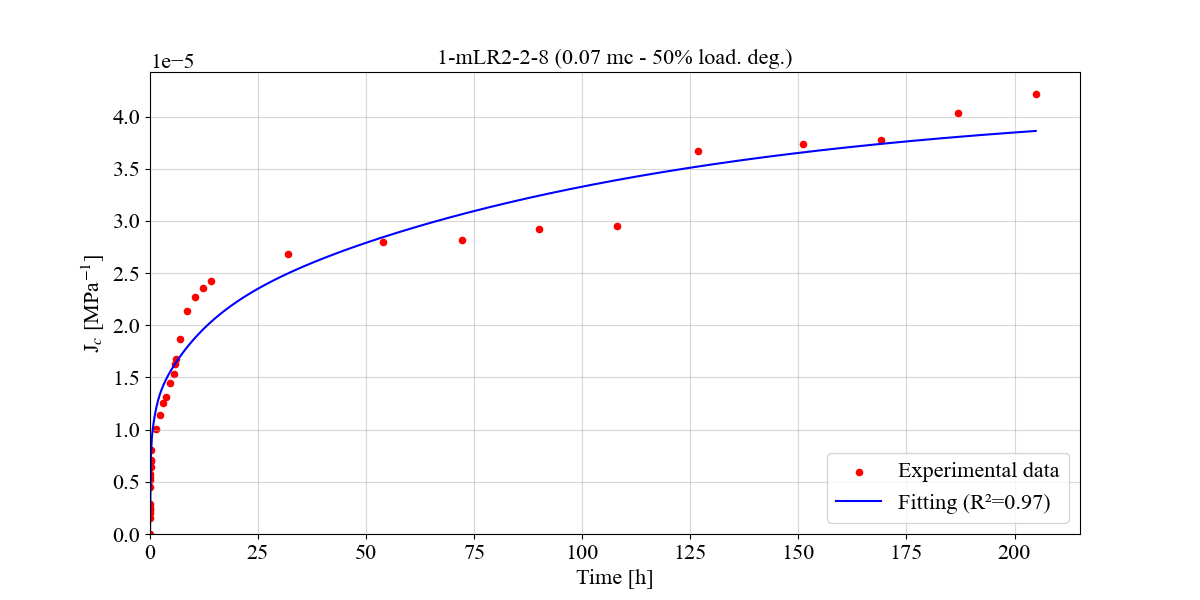

In [3]:
fig, ax_plot1 = plt.subplots(figsize=(12, 6))
fig.canvas.header_visible = False
create_dropdown_widget_sample(folder_path, ax=ax_plot1)

## Plot compliance-time curves sorted by sample type and moisture content
Run the following section to set up an interactive interface for visualizing multiple compliance-time curves, organized by sample type, and moisture content. The interface provides 2 dropdown menus that allow you to customize the plot:

- **Sample Type** lists the different sample types you can choose from, such as **LT-EW**, **LT-LW**, **LR**, **RL**, **RT**, and **TR**.

- **Moisture Content [-]** lists the moisture contents available for selection: **0.07**, **0.12**, and **0.2**, corresponding to **30%**, **65%**, and **90%** relative humidity , respectively.

- **Max Time [h]** to select the maximum time for the Kelvin-Voigt series-based fitting plot.

After selecting a combination of sample type and moisture content, the corresponding compliance-time experimental data is plotted along with the Kelvin-Voigt series-based fitting. Note that curves with shades leaning toward purple correspond to 50% loading degree, while those shifting toward orange correspond to 30% loading degree.

Dropdown(description='Sample Type:', options=('LR', 'LT-EW', 'LT-LW', 'RL', 'RT', 'TR'), style=DescriptionStyl…

Dropdown(description='Moisture Content [-]:', options=(), style=DescriptionStyle(description_width='150px'), v…

IntSlider(value=150, continuous_update=False, description='Max Time [h]:', layout=Layout(width='380px'), max=5…

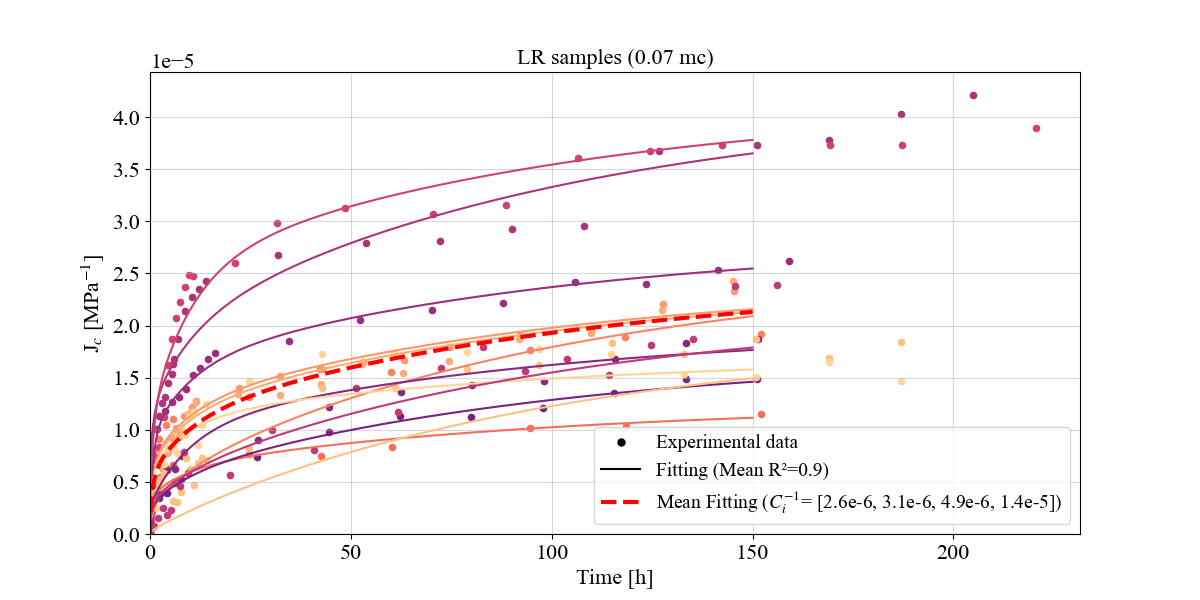

In [4]:
fig, ax_plot2 = plt.subplots(figsize=(12, 6))
fig.canvas.header_visible = False
create_dropdown_widget(folder_path, ax_plot2)

## Plot Boxplots of creep strains and compliances sorted by sample type, loading degree, and moisture content  
Run the following section to set up an interactive interface for visualizing data aggregated as boxplots of:

- **Creep strains ($\boldsymbol{\varepsilon_{c}}$)**
- **Creep compliances ($\boldsymbol{J_{c}^{-1}}$)**

for each sample type, grouped by **loading degree** and **moisture content**. The plotted values correspond to Kelvin-Voigt series-based fitting at the selected time. The interface provides one dropdown menu that allows you to customize the plot:  

- **Time [h]** to select the time at which the boxplots are evaluated.  

IntSlider(value=150, continuous_update=False, description='Time [h]:', layout=Layout(width='380px'), max=500, …

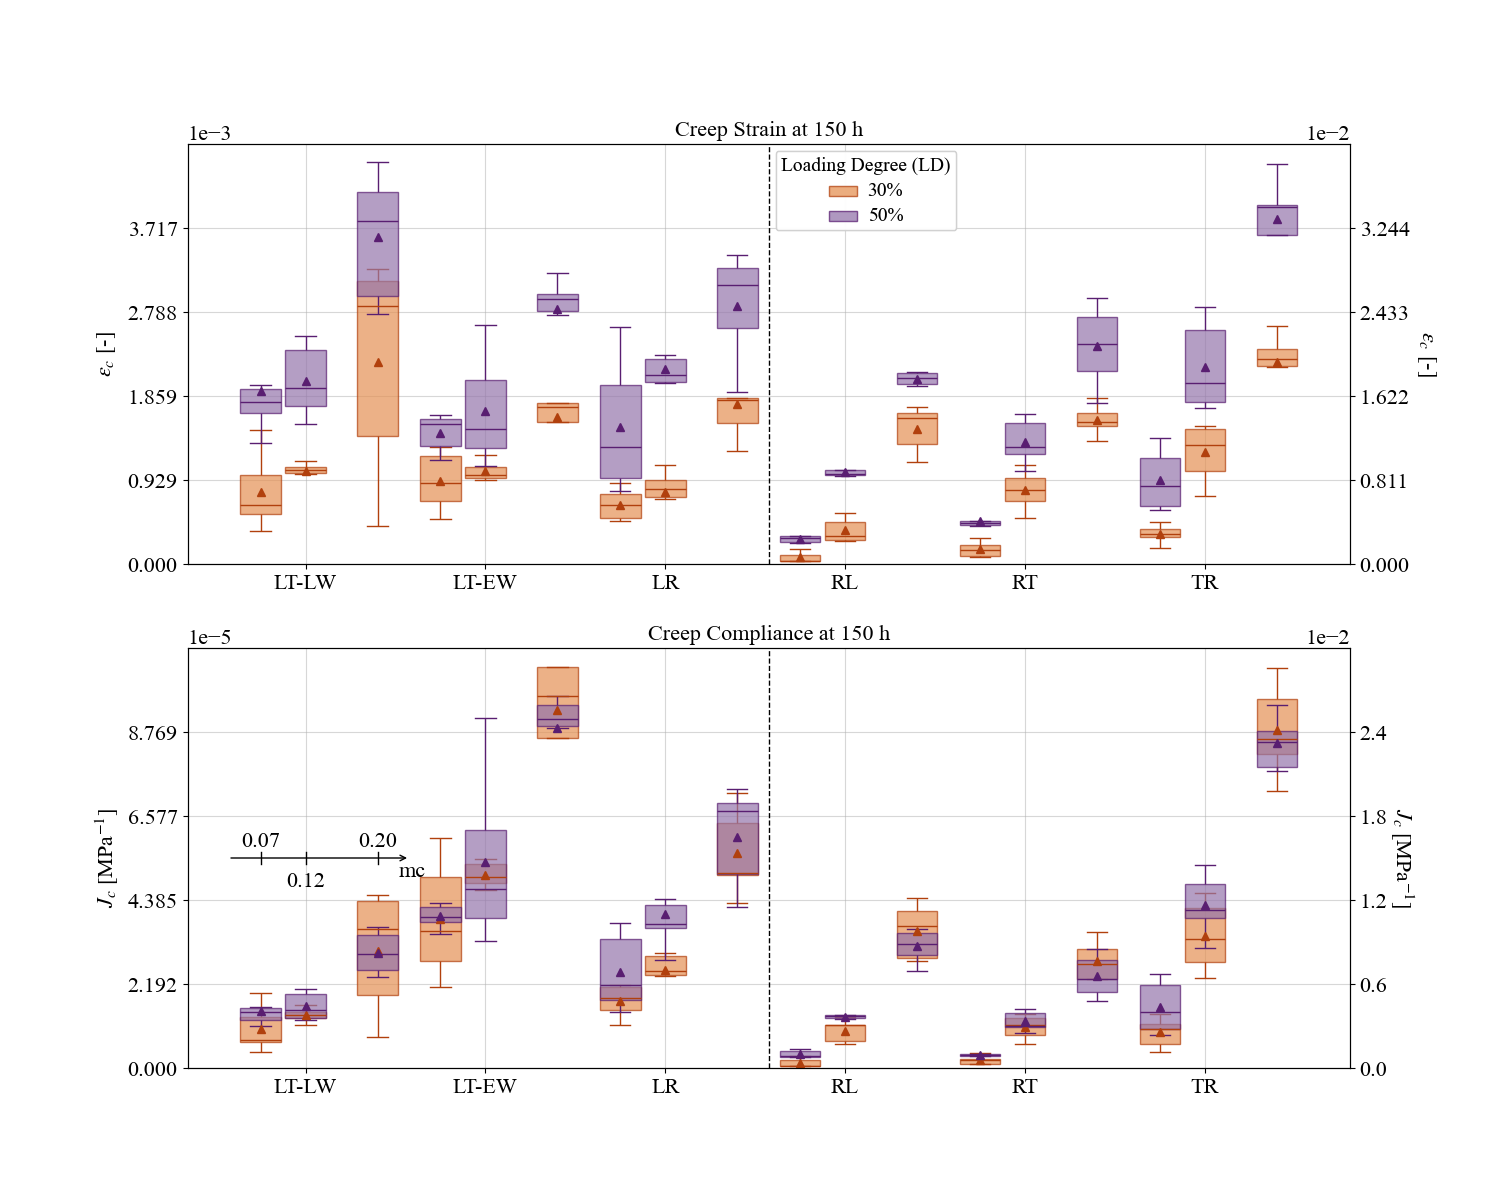

In [5]:
fig, ax_plot3 = plt.subplots(2,1,figsize=(15, 12))
fig.canvas.header_visible = False
ax_plot3 = [*ax_plot3, *[ax.twinx() for ax in list(ax_plot3)]]
create_time_slider_LD(folder_path, ax_plot3)

## Plot boxplots of creep compliances, elsatic compliances, normalized compliances sorted by sample type and moisture content
Run the following section to set up an interactive interface for visualizing data aggregated as boxplots of:

- **Creep compliances ($\boldsymbol{J_{c}^{-1}}$)**
- **Elastic compliances ($\boldsymbol{C_{0}^{-1}}$)** that were previously determined in [*Ferrara and Wittel (2024)*](https://doi.org/10.1515/hf-2024-0046)
- **Normalized compliances ($\boldsymbol{J_{c}^{-1}/C_{0}^{-1}}$)**

for each sample type, grouped by **moisture content**. The plotted values for creep correspond to Kelvin-Voigt series-based fitting at the selected time. The interface provides one dropdown menu that allows you to customize the plot:  

- **Time [h]** to select the time at which the boxplots are evaluated. 

IntSlider(value=150, continuous_update=False, description='Time [h]:', layout=Layout(width='380px'), max=500, …

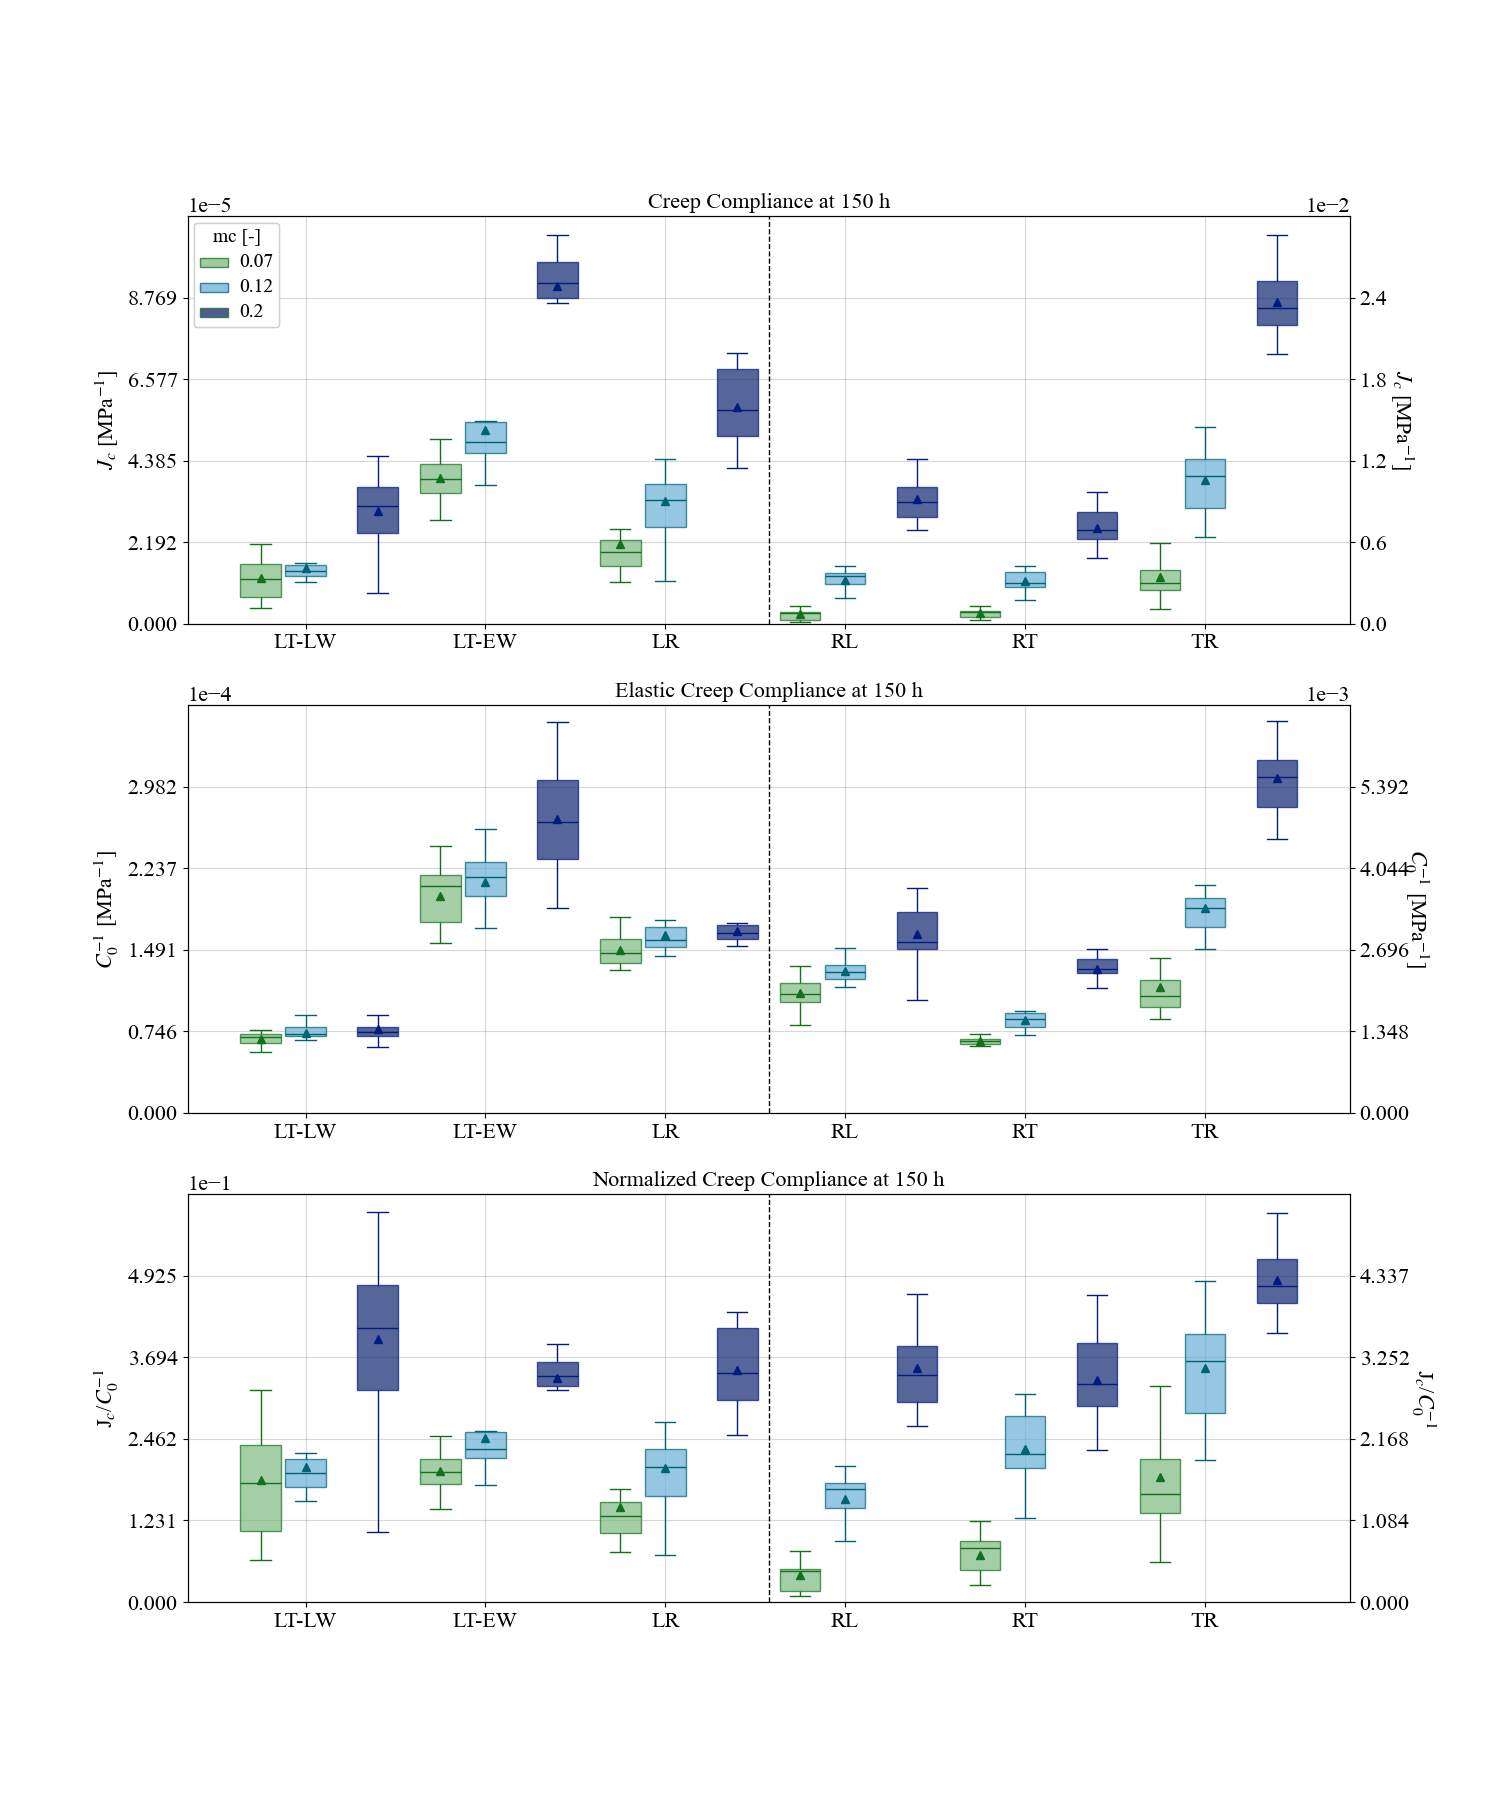

In [6]:
fig, ax_plot4 = plt.subplots(3,1,figsize=(15, 18))
fig.canvas.header_visible = False
ax_plot4 = [*ax_plot4, *[ax.twinx() for ax in list(ax_plot4)]]
create_time_slider_mc(folder_path, ax_plot4)